# Interacting with OpenCLIP

This is a self-contained notebook that shows how to download and run open_clip models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [1]:
import torch
from PIL import Image
import open_clip
import numpy as np
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt

from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# List of available models
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
NVIDIA GeForce RTX 2070 SUPER
12.1


## Multiclass Classification

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32",
    pretrained="laion2b_s34b_b79k",
)
model = model.to(device).eval()

tokenizer = open_clip.get_tokenizer("ViT-B-32")

labels = ["a diagram", "a dog", "a cat", "a person", "a car"]

im = Image.open("./examples/4.jpeg").convert("RGB")
image = preprocess(im).unsqueeze(0).to(device)
text = tokenizer(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features  = model.encode_text(text)

    # Normalize -> cosine similarity
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

    # Similarity scores (cosine * logit_scale)
    # OpenCLIP stores logit_scale as a learnable parameter (log space)
    logit_scale = model.logit_scale.exp()
    text_probs = (logit_scale * (image_features @ text_features.T)).softmax(dim=-1)  # shape [1, num_labels]

# im.show()
print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

Label probs: tensor([[2.2508e-05, 9.9964e-01, 1.2153e-05, 2.8929e-04, 3.7679e-05]],
       device='cuda:0')


## Find Cosine Similarity

In [4]:
model_name = "convnext_base_w"
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name, 
    pretrained='laion2b_s13b_b82k_augreg'
)

model = model.to(device).eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from clip.load() contains a torchvision Transform that performs this preprocessing.

In [5]:
preprocess

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    <function _convert_to_rgb at 0x00000201AE742CA0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

We also use a case-insensitive tokenizer, which can be invoked using tokenizer.tokenize(). By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
tokenizer = open_clip.get_tokenizer(model_name)

tokenizer("Hello world")

tensor([[49406,  3306,  1002, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

We are going to feed 4 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
# images in skimage to use and their textual descriptions
descriptions = {
    "1": "a picture of a cat and a dog together",
    "2": "a person in a car",
    "3": "a person goes to the nature with her happy dog by car",
    "4": "a small happy dog",
}

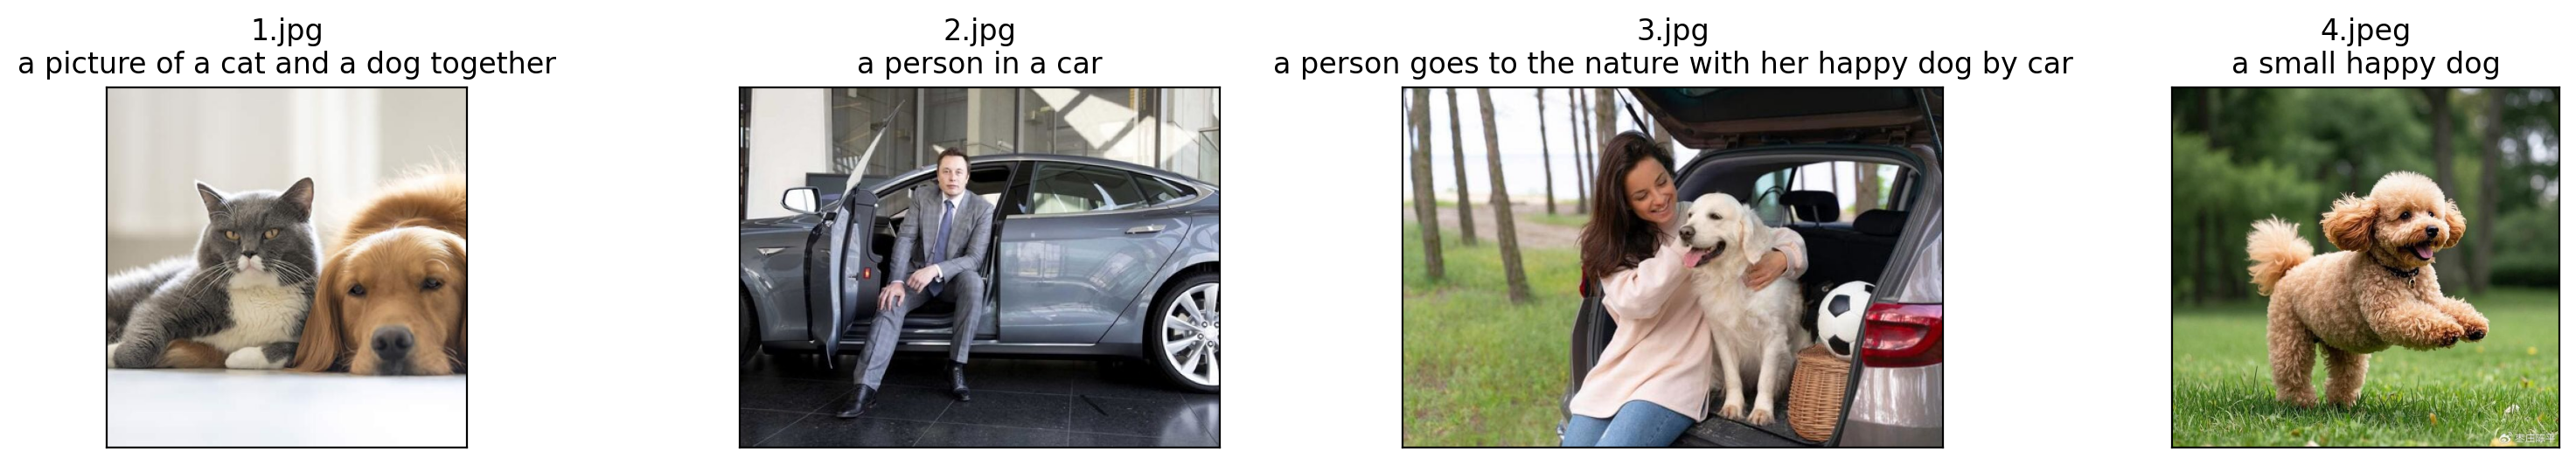

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))
data_dir = "./examples"

for filename in [filename for filename in os.listdir(data_dir) if filename.endswith(".jpeg") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [9]:
image_input = torch.tensor(np.stack(images)).to(device)

text_tokens  = tokenizer(texts).to(device)

In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

    # Normalize -> cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    # Similarity scores 
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

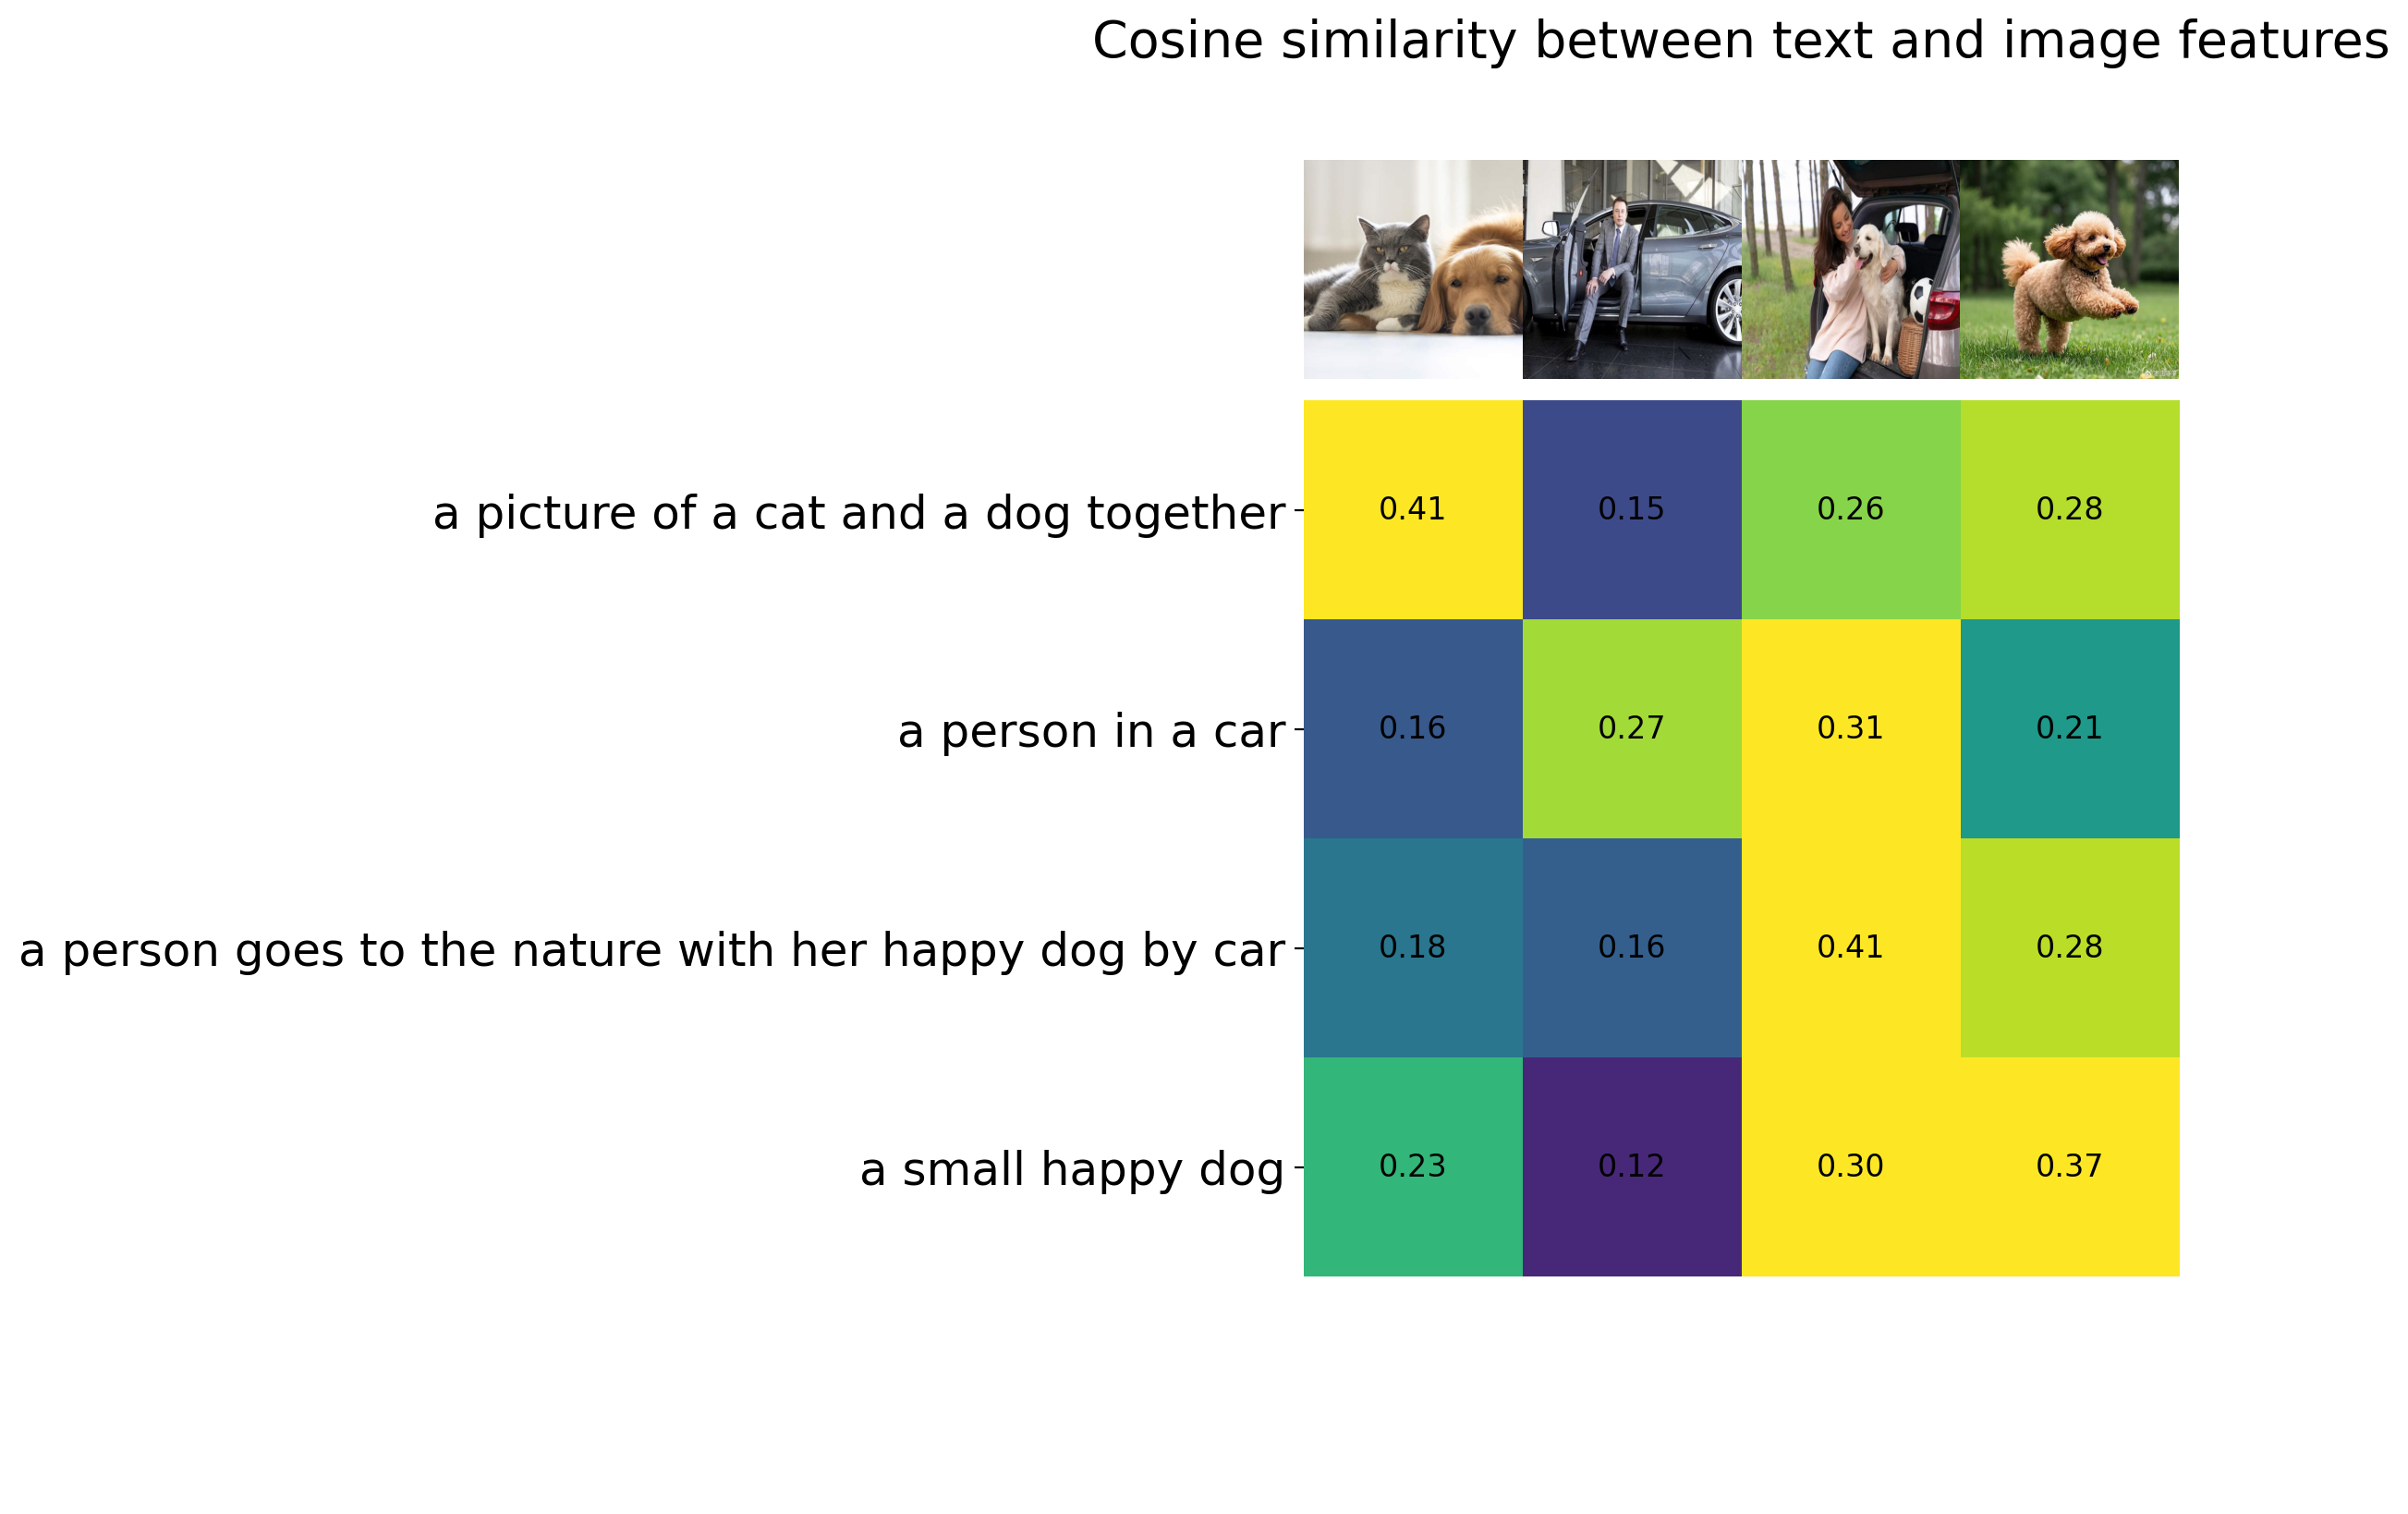

In [11]:
count = len(texts)

plt.figure(figsize=(14, 10))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

We can also define specific tags and try to find them in our iamges.

Text(0.5, 1.0, 'Cosine similarity between text and image features')

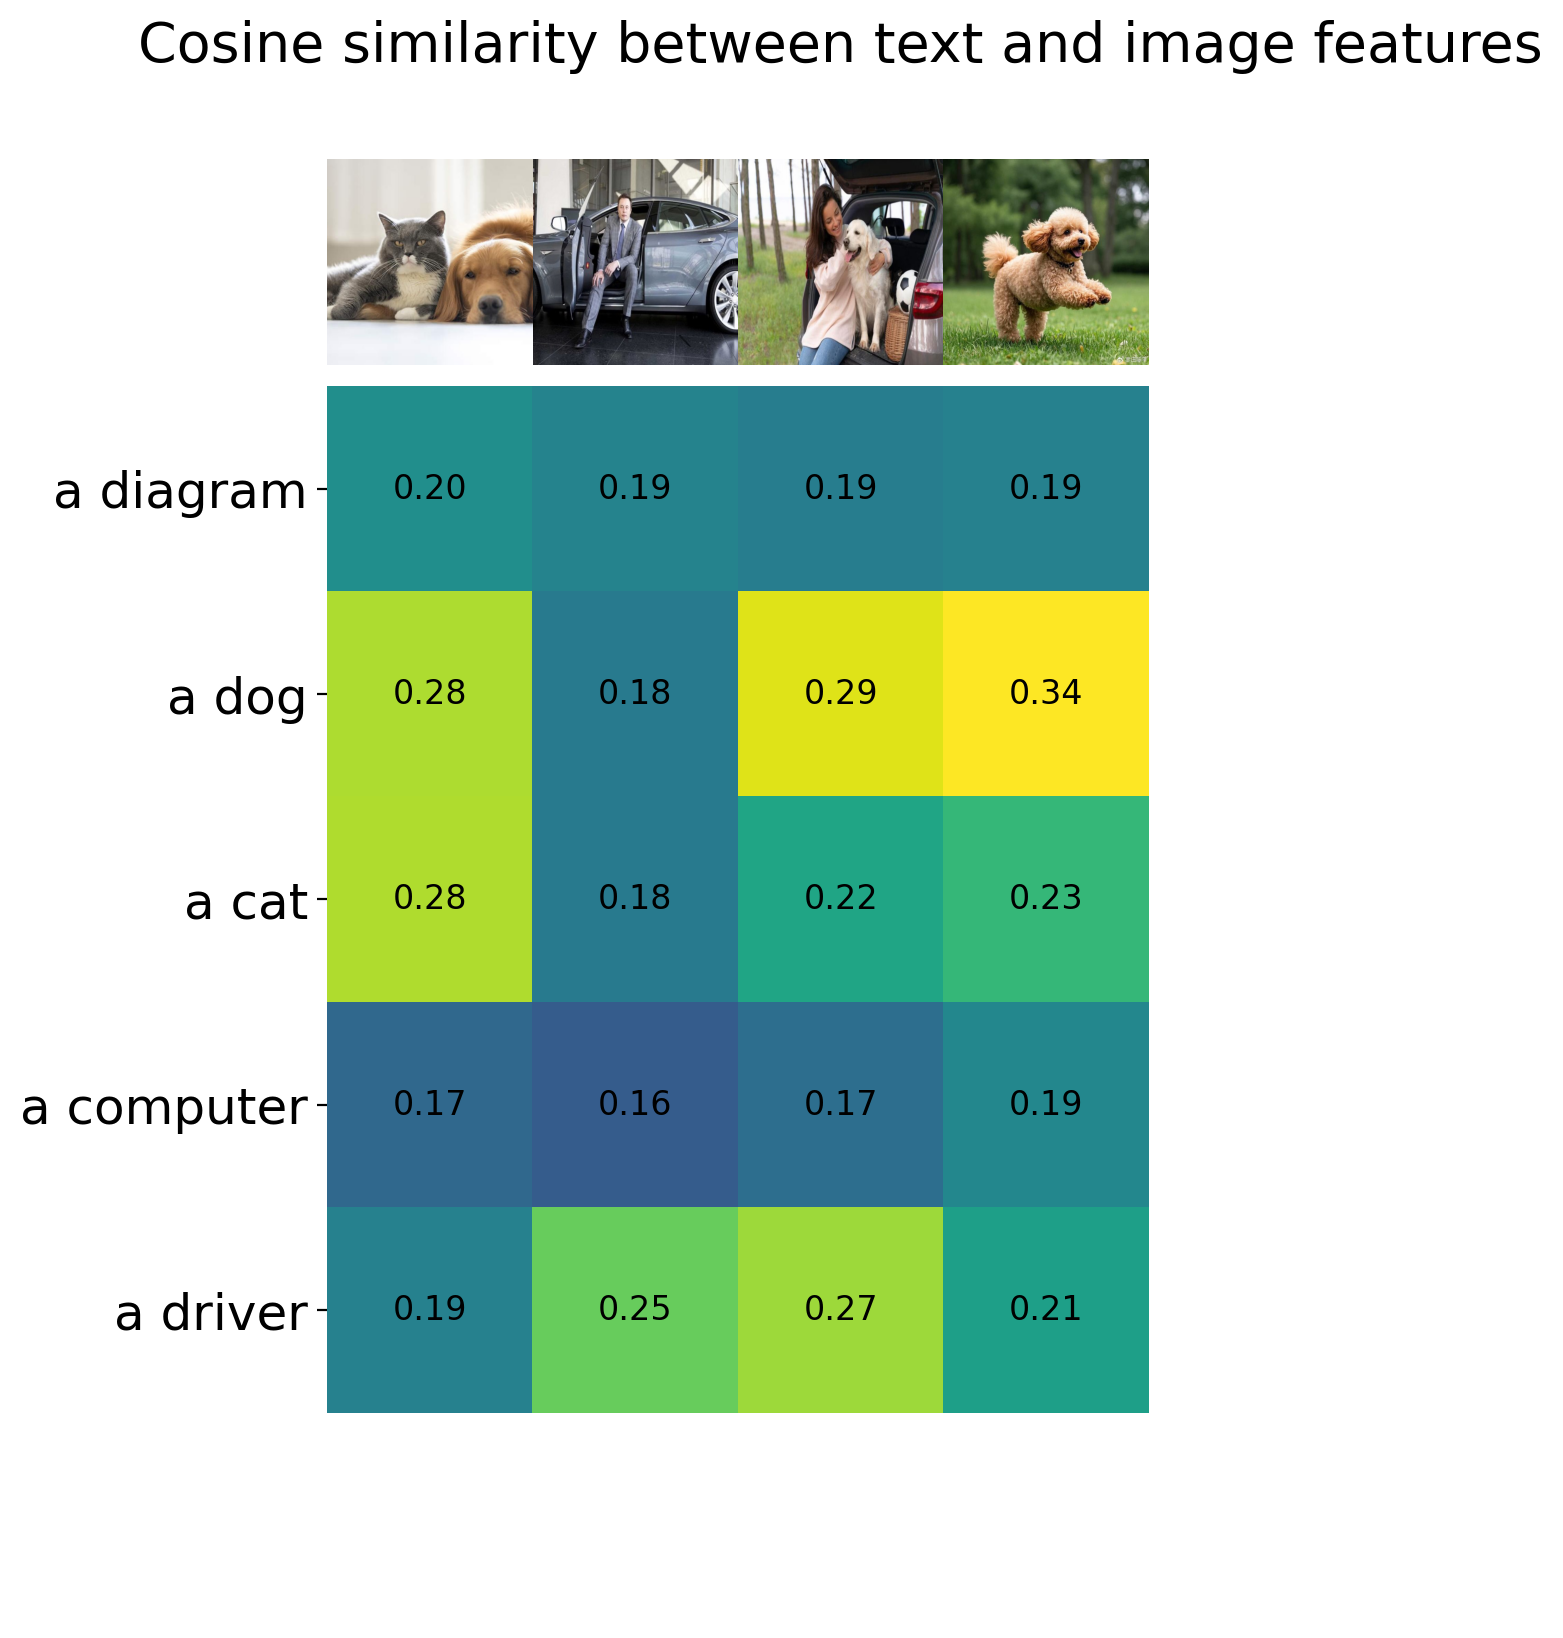

In [12]:
labels = ["a diagram", "a dog", "a cat", "a computer", "a driver"]
label_tokens  = tokenizer(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(label_tokens).float()

    # Normalize -> cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    # Similarity scores 
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(labels)

plt.figure(figsize=(14, 10))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), labels, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)